# Modelos Long-Short Term Memory 

Laboratorio 02 – Series de Tiempo con Deep Learning

Edwin Ortega 22305 - Esteban Zambrano 22119 - Diego García 22404

Para este laboratorio trabajaremos con las series Regular_Imp y Diesel_Con ya que ambas series fueron completamente modeladas y analizadas en el laboratorio 1 además de su disponibilidad de datos adecuados para LSTM.

Link del repositorio:<br>
https://github.com/EstebanZG999/Lab2_DS 

### Librerías necesarias

In [6]:
import numpy as np
import pandas as pd
import warnings
import os
import math
import matplotlib.pyplot as plt
# pip install tensorflow
import tensorflow as tf
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'  # Suprime los logs innecesarios de TensorFlow
warnings.filterwarnings('ignore')         # Suprime los warnings de Python

### Preprocesamiento

##### Cargar el dataset correctamente

In [7]:
df = pd.read_csv("../data/clean/Series_de_Tiempo_Combustibles.csv", parse_dates=["fecha"])
df = df.sort_values("fecha")
df.set_index("fecha", inplace=True)
df.head()

,Regular_Imp,Superior_Imp,Diesel_Imp,Regular_Con,Superior_Con,Diesel_Con
fecha,,,,,,
2000-01-01,NaN,NaN,NaN,202645.20,308156.82,634667.06
2000-02-01,NaN,NaN,NaN,205530.96,307766.31,642380.66
2000-03-01,NaN,NaN,NaN,229499.56,331910.29,699807.25
2000-04-01,NaN,NaN,NaN,210680.40,315648.08,586803.98
2000-05-01,NaN,NaN,NaN,208164.34,319667.97,656948.20


##### Visualización Exploratoria de las Series Temporales

Se grafican las series originales de importación y consumo de combustibles sin aplicar aún ningún filtro o limpieza. Esto para poder identificar tendencias, patrones y posibles problemas en los datos (como valores nulos o ceros).

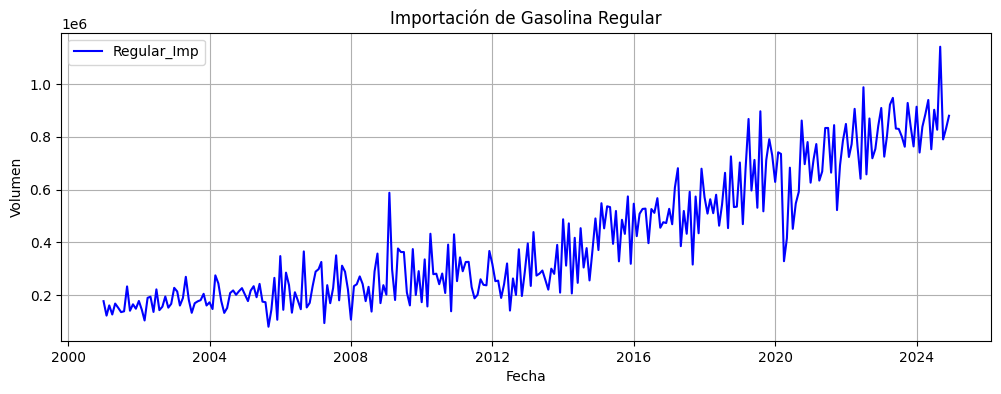

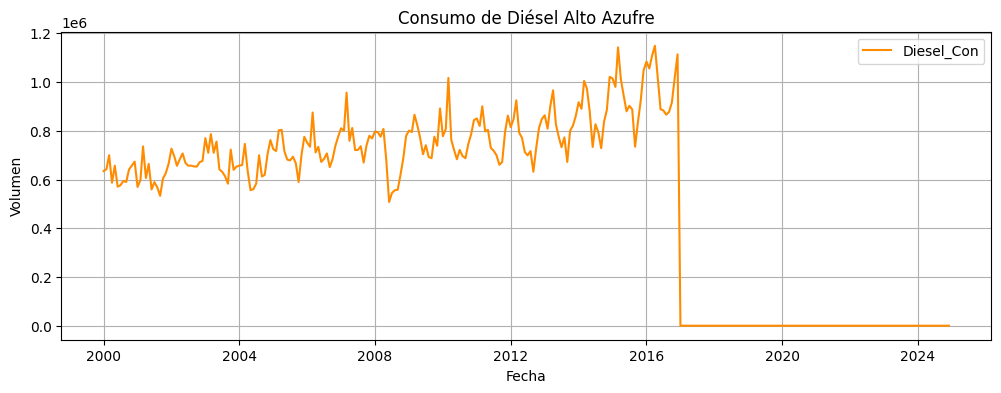

In [8]:
# Series seleccionadas
regular_imp = df["Regular_Imp"].dropna()
diesel_con = df["Diesel_Con"].dropna()

# Graficar Regular_Imp
plt.figure(figsize=(12, 4))
plt.plot(regular_imp, label="Regular_Imp", color='blue')
plt.title("Importación de Gasolina Regular")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid()
plt.legend()
plt.show()

# Graficar Diesel_Con
plt.figure(figsize=(12, 4))
plt.plot(diesel_con, label="Diesel_Con", color='darkorange')
plt.title("Consumo de Diésel Alto Azufre")
plt.xlabel("Fecha")
plt.ylabel("Volumen")
plt.grid()
plt.legend()
plt.show()


**Observaciones:**
- La serie `Regular_Imp` muestra una tendencia creciente constante, ideal para modelado con LSTM.
- La serie `Diesel_Con` se interrumpe drásticamente en 2017, a partir de esa fecha todos los valores son cero.

##### Preprocesamiento de Datos para Modelado LSTM

Se seleccionan y limpian las series relevantes para el modelado. En el caso de `Diesel_Con`, se recorta hasta 2017 para evitar valores nulos o ceros que afecten el entrenamiento. También se eliminan valores nulos en `Regular_Imp`.

In [9]:
# Filtrar Diesel_Con eliminando los ceros finales
diesel_con = diesel_con[diesel_con > 0]

# Escalar ambas series
scaler_reg = MinMaxScaler()
scaler_diesel = MinMaxScaler()

regular_scaled = scaler_reg.fit_transform(regular_imp.values.reshape(-1, 1))
diesel_scaled = scaler_diesel.fit_transform(diesel_con.values.reshape(-1, 1))

# Separar 80% entrenamiento y 20% prueba
def split_data(series_scaled, train_ratio=0.8):
    n = len(series_scaled)
    train_size = int(n * train_ratio)
    return series_scaled[:train_size], series_scaled[train_size:]

train_reg, test_reg = split_data(regular_scaled)
train_diesel, test_diesel = split_data(diesel_scaled)

# Función para crear secuencias LSTM
def create_sequences(data, window_size=12):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i+window_size])
        y.append(data[i+window_size])
    return np.array(X), np.array(y)

window_size = 12  # 12 meses (1 año)

X_reg, y_reg = create_sequences(train_reg, window_size)
X_reg_test, y_reg_test = create_sequences(test_reg, window_size)

X_diesel, y_diesel = create_sequences(train_diesel, window_size)
X_diesel_test, y_diesel_test = create_sequences(test_diesel, window_size)

# Confirmar formas
print("Regular:", X_reg.shape, y_reg.shape)
print("Diesel:", X_diesel.shape, y_diesel.shape)


Regular: (218, 12, 1) (218, 1)
Diesel: (151, 12, 1) (151, 1)


### Modelo LSTM 1 - Importación de Gasolina Regular

##### Escalamiento y generación de secuencias

In [10]:
# Escalar los datos de Regular_Imp
scaler_reg = MinMaxScaler()
regular_scaled = scaler_reg.fit_transform(regular_imp.values.reshape(-1, 1))

# Separar en entrenamiento y prueba (80% entrenamiento)
train_size = int(len(regular_scaled) * 0.8)
train_data = regular_scaled[:train_size]
test_data = regular_scaled[train_size:]

##### Ventanas de tiempo

In [11]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

# Ventanas de 12 meses (1 año)
window_size = 12
X_train, y_train = create_sequences(train_data, window_size)
X_test, y_test = create_sequences(test_data, window_size)

print("X_train:", X_train.shape, "y_train:", y_train.shape)
print("X_test:", X_test.shape, "y_test:", y_test.shape)

X_train: (218, 12, 1) y_train: (218, 1)
X_test: (46, 12, 1) y_test: (46, 1)


##### Construcción modelo LSTM

In [12]:
# Definir modelo
model_reg = Sequential()
model_reg.add(LSTM(64, activation='tanh', input_shape=(window_size, 1)))
model_reg.add(Dense(1))  # salida univariada

# Compilar modelo
model_reg.compile(optimizer='adam', loss='mse')

# Entrenar modelo
history = model_reg.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=100,
    batch_size=16,
    verbose=1
)

Epoch 1/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 21ms/step - loss: 0.0406 - val_loss: 0.0103
Epoch 2/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0128 - val_loss: 0.0302
Epoch 3/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0070 - val_loss: 0.0090
Epoch 4/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0065 - val_loss: 0.0094
Epoch 5/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0063 - val_loss: 0.0136
Epoch 6/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0064 - val_loss: 0.0117
Epoch 7/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0054 - val_loss: 0.0102
Epoch 8/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0061 - val_loss: 0.0144
Epoch 9/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0079 - val_loss: 0.0092
Epoch 10/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0076 - val_loss: 0.0098
Epoch 11/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 8ms/step - loss: 0.0070 - val_loss: 0.0127
Epoch 12/100
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.

##### Visualización del loss

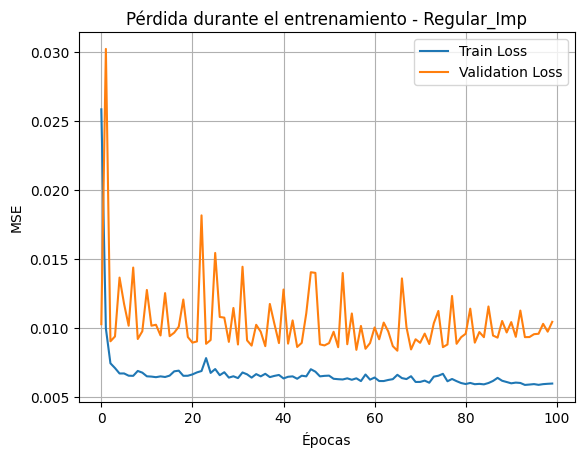

In [13]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title("Pérdida durante el entrenamiento - Regular_Imp")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()

### Modelo 2 LSTM - Gasolina Regular 

##### Escalamiento y generación de secuencias

In [14]:
scaler_reg2 = MinMaxScaler()
regular_scaled2 = scaler_reg2.fit_transform(regular_imp.values.reshape(-1, 1))

train_size_reg2 = int(len(regular_scaled2) * 0.8)
train_data_reg2 = regular_scaled2[:train_size_reg2]
test_data_reg2 = regular_scaled2[train_size_reg2:]

##### Ventanas de tiempo

In [15]:
window_size = 12

def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

X_train_reg2, y_train_reg2 = create_sequences(train_data_reg2, window_size)
X_test_reg2, y_test_reg2 = create_sequences(test_data_reg2, window_size)

print("X_train:", X_train_reg2.shape, "y_train:", y_train_reg2.shape)
print("X_test:", X_test_reg2.shape, "y_test:", y_test_reg2.shape)


X_train: (218, 12, 1) y_train: (218, 1)
X_test: (46, 12, 1) y_test: (46, 1)


##### Construcción modelo LSTM 2

In [16]:
model_reg2 = Sequential()
model_reg2.add(LSTM(64, activation='tanh', return_sequences=True, input_shape=(window_size, 1)))
model_reg2.add(Dropout(0.2))
model_reg2.add(LSTM(32, activation='tanh'))
model_reg2.add(Dense(1))
model_reg2.compile(optimizer=Adam(learning_rate=9.5e-4), loss='mse')

es_reg2 = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_reg2 = model_reg2.fit(
    X_train, y_train,
    validation_data=(X_test, y_test),
    epochs=200,
    batch_size=16,
    callbacks=[es_reg2],
    verbose=1
)

Epoch 1/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 2s 30ms/step - loss: 0.0565 - val_loss: 0.0097
Epoch 2/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0136 - val_loss: 0.0277
Epoch 3/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0061 - val_loss: 0.0091
Epoch 4/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0066 - val_loss: 0.0096
Epoch 5/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0071 - val_loss: 0.0091
Epoch 6/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0076 - val_loss: 0.0131
Epoch 7/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0070 - val_loss: 0.0095
Epoch 8/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0068 - val_loss: 0.0094
Epoch 9/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0072 - val_loss: 0.0093
Epoch 10/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0062 - val_loss: 0.0166
Epoch 11/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0076 - val_loss: 0.0090
Epoch 12/200
14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - l

### Visualización del loss

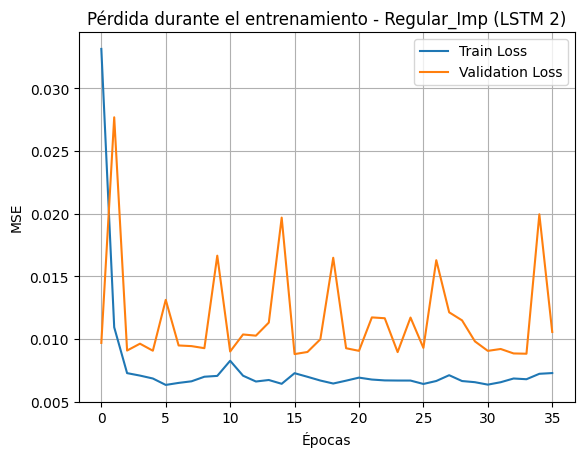

In [17]:
plt.plot(history_reg2.history['loss'], label='Train Loss')
plt.plot(history_reg2.history['val_loss'], label='Validation Loss')
plt.title("Pérdida durante el entrenamiento - Regular_Imp (LSTM 2)")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()

### Modelo LSTM 1 - Consumo de Diesel

##### Preparar la serie

In [18]:
# Escalar los datos de Diesel_Con
scaler_diesel = MinMaxScaler()
diesel_scaled = scaler_diesel.fit_transform(diesel_con.values.reshape(-1, 1))

# Separar en entrenamiento y prueba
train_size_d = int(len(diesel_scaled) * 0.8)
train_diesel = diesel_scaled[:train_size_d]
test_diesel = diesel_scaled[train_size_d:]

##### Secuencias

In [19]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 12  # un año

X_train_diesel, y_train_diesel = create_sequences(train_diesel, window_size)
X_test_diesel, y_test_diesel = create_sequences(test_diesel, window_size)

print("X_train_diesel:", X_train_diesel.shape, "y_train_diesel:", y_train_diesel.shape)
print("X_test_diesel:", X_test_diesel.shape, "y_test_diesel:", y_test_diesel.shape)

X_train_diesel: (151, 12, 1) y_train_diesel: (151, 1)
X_test_diesel: (29, 12, 1) y_test_diesel: (29, 1)


##### Construcción del LSTM

In [20]:
model_diesel = Sequential()
model_diesel.add(LSTM(64, activation='tanh', input_shape=(window_size, 1)))
model_diesel.add(Dense(1))

# Compilar modelo
model_diesel.compile(optimizer='adam', loss='mse')

# Entrenar modelo
history_diesel = model_diesel.fit(
    X_train_diesel, y_train_diesel,
    validation_data=(X_test_diesel, y_test_diesel),
    epochs=100,
    batch_size=16,
    verbose=1
)

Epoch 1/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 1s 27ms/step - loss: 0.0981 - val_loss: 0.0856
Epoch 2/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0220 - val_loss: 0.0369
Epoch 3/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0222 - val_loss: 0.0854
Epoch 4/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0222 - val_loss: 0.0612
Epoch 5/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0207 - val_loss: 0.0525
Epoch 6/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0152 - val_loss: 0.0590
Epoch 7/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0153 - val_loss: 0.0568
Epoch 8/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0172 - val_loss: 0.0498
Epoch 9/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0132 - val_loss: 0.0584
Epoch 10/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0158 - val_loss: 0.0511
Epoch 11/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0165 - val_loss: 0.0505
Epoch 12/100
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.

##### Visualización

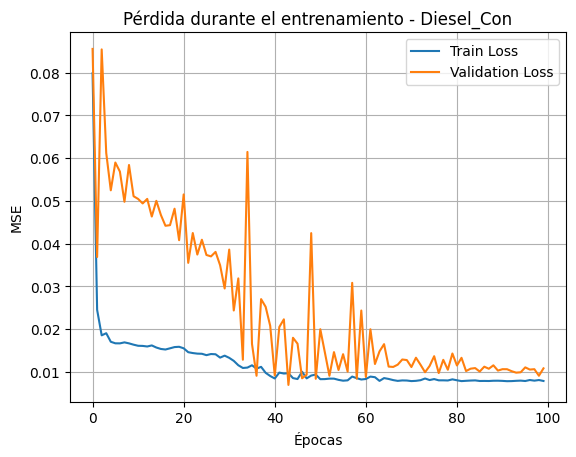

In [21]:
plt.plot(history_diesel.history['loss'], label='Train Loss')
plt.plot(history_diesel.history['val_loss'], label='Validation Loss')
plt.title("Pérdida durante el entrenamiento - Diesel_Con")
plt.xlabel("Épocas")
plt.ylabel("MSE")
plt.legend()
plt.grid()
plt.show()


### Modelo 2 LSTM - Consumo de Diesel 

##### Preparar la serie

In [22]:
scaler_diesel = MinMaxScaler()
diesel_scaled = scaler_diesel.fit_transform(diesel_con.values.reshape(-1, 1))

train_size_diesel = int(len(diesel_scaled) * 0.8)
train_data_diesel = diesel_scaled[:train_size_diesel]
test_data_diesel = diesel_scaled[train_size_diesel:]

##### Secuencias

In [23]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:i + window_size])
        y.append(data[i + window_size])
    return np.array(X), np.array(y)

window_size = 12
X_train_diesel, y_train_diesel = create_sequences(train_data_diesel, window_size)
X_test_diesel, y_test_diesel = create_sequences(test_data_diesel, window_size)

print("X_train:", X_train_diesel.shape, "y_train:", y_train_diesel.shape)
print("X_test:", X_test_diesel.shape, "y_test:", y_test_diesel.shape)

X_train: (151, 12, 1) y_train: (151, 1)
X_test: (29, 12, 1) y_test: (29, 1)


##### Construcción del LSTM 2

In [24]:
model_diesel2 = Sequential()
model_diesel2.add(LSTM(96, activation='tanh', return_sequences=True, input_shape=(window_size, 1)))
model_diesel2.add(Dropout(0.2))
model_diesel2.add(LSTM(32, activation='tanh'))
model_diesel2.add(Dense(1))
model_diesel2.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')

es_diesel2 = EarlyStopping(monitor='val_loss', patience=20, restore_best_weights=True)
history_diesel2 = model_diesel2.fit(
    X_train_diesel, y_train_diesel,
    validation_data=(X_test_diesel, y_test_diesel),
    epochs=200,
    batch_size=16,
    callbacks=[es_diesel2],
    verbose=1
)


Epoch 1/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 2s 42ms/step - loss: 0.0670 - val_loss: 0.0413
Epoch 2/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0244 - val_loss: 0.0874
Epoch 3/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0186 - val_loss: 0.0452
Epoch 4/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0197 - val_loss: 0.0509
Epoch 5/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0178 - val_loss: 0.0635
Epoch 6/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0191 - val_loss: 0.0475
Epoch 7/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0174 - val_loss: 0.0644
Epoch 8/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0152 - val_loss: 0.0477
Epoch 9/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0165 - val_loss: 0.0560
Epoch 10/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0164 - val_loss: 0.0488
Epoch 11/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 12ms/step - loss: 0.0160 - val_loss: 0.0559
Epoch 12/200
10/10 ━━━━━━━━━━━━━━━━━━━━ 0s 13ms/step

##### Visualización

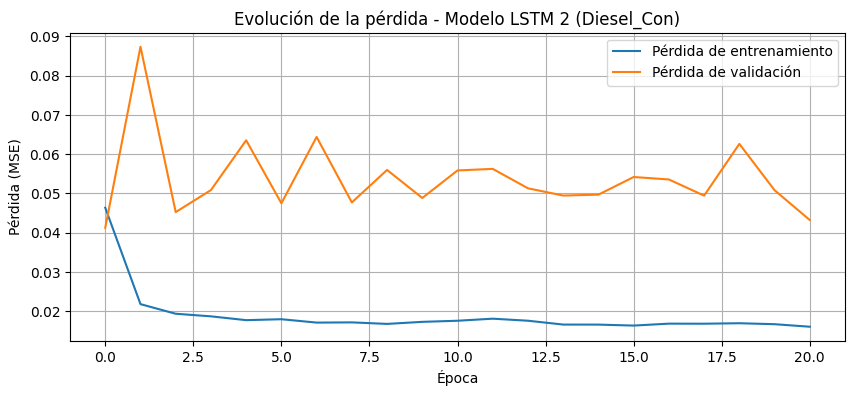

In [25]:
plt.figure(figsize=(10, 4))
plt.plot(history_diesel2.history['loss'], label='Pérdida de entrenamiento')
plt.plot(history_diesel2.history['val_loss'], label='Pérdida de validación')
plt.title('Evolución de la pérdida - Modelo LSTM 2 (Diesel_Con)')
plt.xlabel('Época')
plt.ylabel('Pérdida (MSE)')
plt.grid(True)
plt.legend()
plt.show()

7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 18ms/step
== Resultados Regular_Imp ==


,model,train_MAE,train_RMSE,train_MAPE,test_MAE,test_RMSE,test_MAPE
1,LSTM64_32_w12_do02,65177.216792,84665.212523,23.491859,80437.051957,99415.729632,10.160390
0,LSTM64_w12,62653.915705,80906.020154,23.193606,89035.921685,108313.132758,11.512002


Mejor modelo Regular_Imp: LSTM64_32_w12_do02
7/7 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step


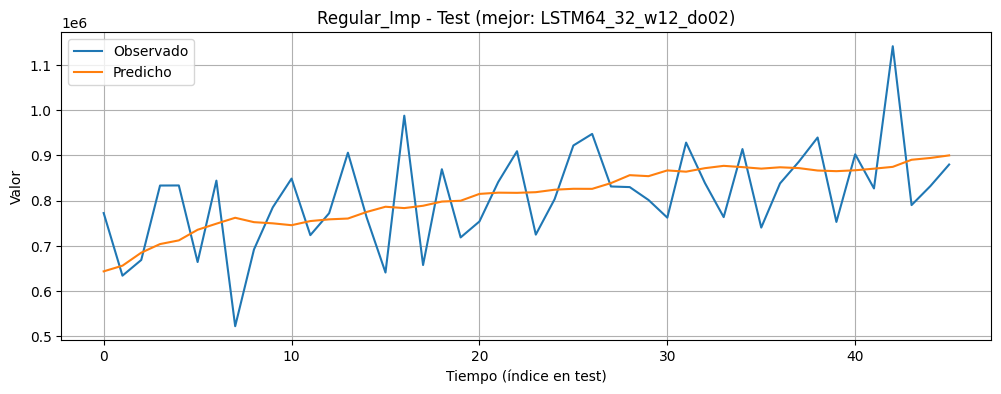

5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
== Resultados Diesel_Con ==


,model,train_MAE,train_RMSE,train_MAPE,test_MAE,test_RMSE,test_MAPE
0,LSTM64_w12,42954.846851,56355.707816,6.031005,52968.942660,66711.073267,5.669439
1,LSTM96_w12_do02,95097.068119,114894.153218,14.134677,111213.311626,130295.650856,12.439860


Mejor modelo Diesel_Con: LSTM64_w12
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 30ms/step


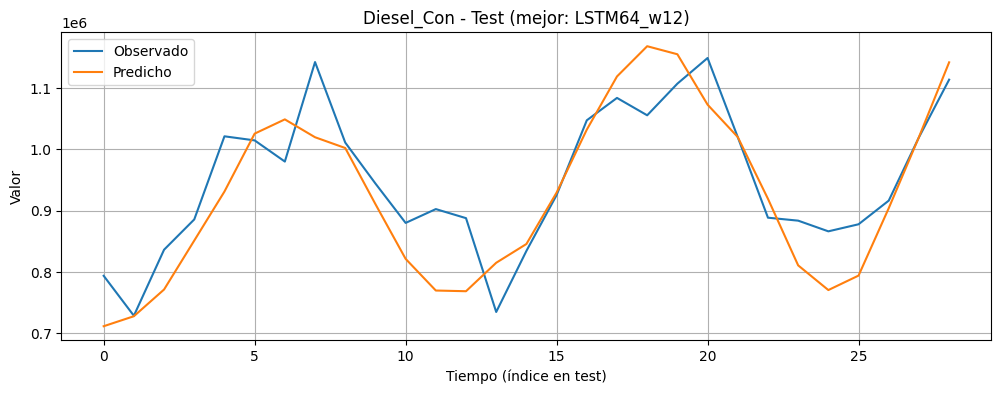

In [27]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def mape(y_true, y_pred):
    y_true = np.asarray(y_true).reshape(-1, 1)
    y_pred = np.asarray(y_pred).reshape(-1, 1)
    return np.mean(np.abs((y_true - y_pred) / np.clip(np.abs(y_true), 1e-8, None))) * 100

def evaluate_on_original_scale(model, Xtr, ytr, Xte, yte, scaler):
    """
    Devuelve métricas (MAE, RMSE, MAPE) en escala original y las series (train_true, train_pred, test_true, test_pred).
    """
    # Predicciones en escala normalizada
    ytr_pred_sc = model.predict(Xtr)
    yte_pred_sc = model.predict(Xte)

    # Regresar a escala original
    ytr_true = scaler.inverse_transform(ytr.reshape(-1, 1))
    yte_true = scaler.inverse_transform(yte.reshape(-1, 1))
    ytr_pred = scaler.inverse_transform(ytr_pred_sc)
    yte_pred = scaler.inverse_transform(yte_pred_sc)

    metrics = {
        "train_MAE": float(mean_absolute_error(ytr_true, ytr_pred)),
        "train_RMSE": float(np.sqrt(mean_squared_error(ytr_true, ytr_pred))),
        "train_MAPE": float(mape(ytr_true, ytr_pred)),
        "test_MAE": float(mean_absolute_error(yte_true, yte_pred)),
        "test_RMSE": float(np.sqrt(mean_squared_error(yte_true, yte_pred))),
        "test_MAPE": float(mape(yte_true, yte_pred)),
    }
    series = (ytr_true.flatten(), ytr_pred.flatten(), yte_true.flatten(), yte_pred.flatten())
    return metrics, series

def plot_obs_vs_pred(y_true, y_pred, title):
    plt.figure(figsize=(12, 4))
    plt.plot(y_true, label="Observado")
    plt.plot(y_pred, label="Predicho")
    plt.title(title)
    plt.xlabel("Tiempo (índice en test)")
    plt.ylabel("Valor")
    plt.grid(True)
    plt.legend()
    plt.show()

# ========= REGULAR_Imp =========
# Si luego agregas más modelos, colócalos aquí:
models_reg = {
    "LSTM64_w12":           model_reg,
    "LSTM64_32_w12_do02":   model_reg2
}

results_reg = []
preds_store_reg = {}

for name, mdl in models_reg.items():
    mets, series = evaluate_on_original_scale(
        mdl, X_train, y_train, X_test, y_test, scaler_reg
    )
    row = {"model": name, **mets}
    results_reg.append(row)
    preds_store_reg[name] = series

df_reg = pd.DataFrame(results_reg).sort_values("test_RMSE")
best_reg_name = df_reg.iloc[0]["model"]
best_reg_model = models_reg[best_reg_name]
print("== Resultados Regular_Imp ==")
display(df_reg)
print(f"Mejor modelo Regular_Imp: {best_reg_name}")

# Graficar observados vs predichos para el mejor modelo
_, (y_train_true_reg, y_train_pred_reg, y_test_true_reg, y_test_pred_reg) = evaluate_on_original_scale(
    best_reg_model, X_train, y_train, X_test, y_test, scaler_reg
)
plot_obs_vs_pred(y_test_true_reg, y_test_pred_reg, f"Regular_Imp - Test (mejor: {best_reg_name})")

# ========= DIESEL_Con =========
models_diesel = {
    "LSTM64_w12":       model_diesel,
    "LSTM96_w12_do02":  model_diesel2
}

results_diesel = []
preds_store_diesel = {}

for name, mdl in models_diesel.items():
    mets, series = evaluate_on_original_scale(
        mdl, X_train_diesel, y_train_diesel, X_test_diesel, y_test_diesel, scaler_diesel
    )
    row = {"model": name, **mets}
    results_diesel.append(row)
    preds_store_diesel[name] = series

df_diesel = pd.DataFrame(results_diesel).sort_values("test_RMSE")
best_diesel_name = df_diesel.iloc[0]["model"]
best_diesel_model = models_diesel[best_diesel_name]
print("== Resultados Diesel_Con ==")
display(df_diesel)
print(f"Mejor modelo Diesel_Con: {best_diesel_name}")

# Graficar observados vs predichos para el mejor modelo
_, (y_train_true_diesel, y_train_pred_diesel, y_test_true_diesel, y_test_pred_diesel) = evaluate_on_original_scale(
    best_diesel_model, X_train_diesel, y_train_diesel, X_test_diesel, y_test_diesel, scaler_diesel
)
plot_obs_vs_pred(y_test_true_diesel, y_test_pred_diesel, f"Diesel_Con - Test (mejor: {best_diesel_name})")
